<a href="https://colab.research.google.com/github/anurag-3-nair/Neural-Networks/blob/main/Problem_A_03804467.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased.

The equations governing the static response of the rod are:
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import h5py
dtype = torch.float32

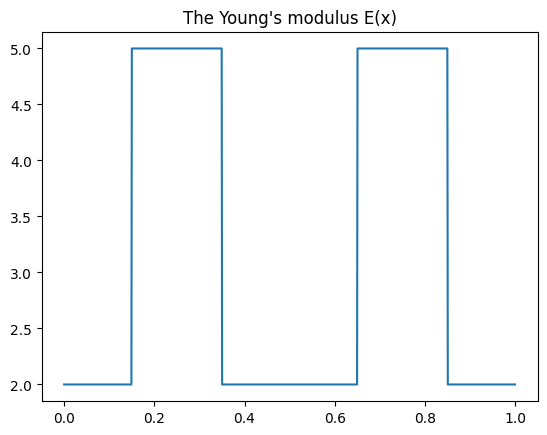

In [ ]:
# Changed to use Pytorch instead of Numpy
def E(x, phase1=2., phase2=5.):
    '''Young's modulus'''
    return torch.where(torch.abs(x - 0.5) < 0.35,
                       torch.where(torch.abs(x - 0.5) > 0.15,phase2, phase1),
                       phase1)

# New: X values for plotting
x_np = np.linspace(0., 1., 1000)
x_torch = torch.tensor(x_np, dtype=torch.float32)

# E(x) using torch
e_torch = E(x_torch)

# Numpy for
e_np = e_torch.detach().numpy()

# Plotting
plt.figure()
plt.plot(x_np,e_np)
plt.title("The Young's modulus E(x)")
plt.show()

In [ ]:
from re import U
device = torch.device('cpu')
print(f"Using device: {device}")

E_train = E(x_torch).to(device)

# Load dataset

with h5py.File('/content/drive/MyDrive/DPL4PDE_Project/LinearElasticity1d(1).h5', 'r') as file:
  print(file.keys())
  x_test = torch.tensor(np.array(file['x_test']), dtype=dtype).to(device)
  u_test = torch.tensor(np.array(file['u_test']), dtype=dtype).to(device)

u_test_dev = u_test.unsqueeze(1)
u_test = u_test_dev.repeat(1,1)

print(f'Shape of x_test: ', x_test.shape)
print(f'Shape of u_test: ', u_test.shape)

# Applied Activation function
class CustomActivation(nn.Module):
    def forward(self, x):
        x = torch.tanh(x)
        x = torch.sin(torch.pi * x + torch.pi)
        return x

# Neural Network Definition
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()

        # Activation
        self.activation = nn.Tanh()

        layers = []
        activation = CustomActivation()
        for i in range(len(layers_list) - 2):
            layers.append(nn.Linear(layers_list[i], layers_list[i + 1], dtype=dtype))
            layers.append(activation)
        # Final output layer (no activation)
        layers.append(nn.Linear(layers_list[-2], layers_list[-1], dtype=dtype))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
      return self.net(x)

#
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
x = torch.randn(10, 1).to(device)
print(next(model_u.parameters()).shape)
from torchsummary import summary
summary(model_u, input_size=(1,), device=str(device))

Using device: cpu
<KeysViewHDF5 ['u_test', 'x_test']>
Shape of x_test:  torch.Size([1001, 1])
Shape of u_test:  torch.Size([1001, 1])
torch.Size([40, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
  CustomActivation-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
  CustomActivation-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
  CustomActivation-6                   [-1, 40]               0
            Linear-7                   [-1, 40]           1,640
  CustomActivation-8                   [-1, 40]               0
            Linear-9                    [-1, 1]              41
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
----------------------------------------------------------------
Input si

Size of boundary points: torch.Size([2, 1])
Size of integral points: torch.Size([1001, 1])
Size of testing points: torch.Size([1001, 1])


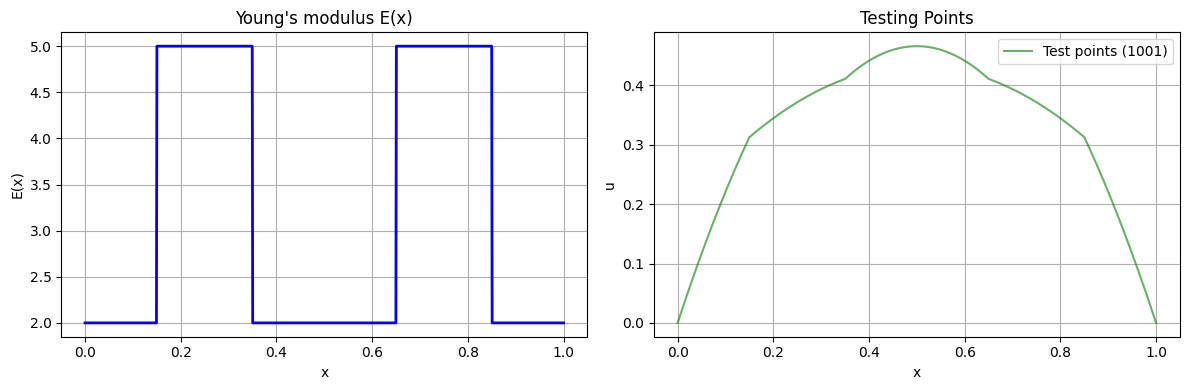

In [ ]:
lb, ub = [0.], [1.]
n_int = u_test.shape[0]  # same number as u_test
dataType = torch.float32
np.random.seed(1234)
################################# The boundary points (x=0) and (x=1)
x_lb = np.array(lb)
x_rb = np.array(ub)
#
x_bd = np.vstack([x_lb, x_rb])
x_bd = torch.tensor(x_bd, dtype=dataType)
u_bd = torch.tensor([[1.], [0.]], dtype=dataType)
print('Size of boundary points:', x_bd.shape)

################################# The integral points (x)
x_int, w_int = np.polynomial.legendre.leggauss(n_int)
x_int = torch.tensor(x_int, dtype=dataType).unsqueeze(-1)
w_int = torch.tensor(w_int, dtype=dataType).reshape(-1,1)
print('Size of integral points:', x_int.shape)

################################# The testing dataset (x,u)
x_test = x_test.clone().detach().to(dataType)
u_test = u_test.clone().detach().to(dataType)
print('Size of testing points:', x_test.shape)

# plt.figure(figsize=(6, 5))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot 1: E(x) function
x_plot_np = x_np
x_plot_torch = x_torch
e_plot_torch = E(x_plot_torch)
e_plot_np = e_plot_torch.detach().numpy()

axs[0].plot(x_plot_np, e_plot_np, 'b-', linewidth=2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('E(x)')
axs[0].set_title("Young's modulus E(x)")
axs[0].grid(True)

# Plot 2: Test points
axs[1].plot(x_test.cpu().numpy(), u_test.cpu().numpy(),
            color='green', alpha=0.6, label=f'Test points ({len(x_test)})')
axs[1].set_xlabel('x')
axs[1].set_ylabel('u')
axs[1].set_title('Testing Points')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Defining Loss Function

In [ ]:
from re import U
from torch.autograd import grad, Variable
from tqdm import trange

#
torch.manual_seed(1234)

class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        '''Apply mollifier for BCs'''
        if self.dim == 1:
          # To enforce u(0) = u(1) = 0
          return u * x * (1-x)
        else:
          for d in range(self.dim):
              u = u*torch.cos(torch.pi/2*x[...,d:d+1])
          return u

class LossClass(object):
  def __init__(self, u_model):
    self.device = device
    self.u_model = u_model
    self.getLoss = torch.nn.MSELoss()
    self.mollifier = Mollifier(1) #1D Mollifier

  def loss_bd(self, x_bd, u_bd):
    '''loss term related to boundary condition'''
    ############## Loss term related to the boundary condition
    x = self.u_model(x_bd.to(self.device))
    loss = self.getLoss(x, u_bd.to(self.device))

    return loss

  def loss_pde(self, x_int, w_int):
    '''Deep Ritz energy functional'''
    # Integral points
    ################# The PDE loss
    x = 0.5 * x_int + 0.5 # Transfer x_int to the interval [0,1]
    x = Variable(x, requires_grad=True).to(self.device)
    w = w_int.to(self.device)

    ######### Energy Functional
    x = Variable(x_int, requires_grad=True)#.to(self.device)

    # Forward pass
    u = self.u_model(x)
    u = self.mollifier.apply(u, x)

    # Compute derivative du/dx
    du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Evaluating Young's modulus
    E_x = E(x)

    # Body force (gravity)
    f = 9.81

    # Energy functional
    energy_density = (0.5 * E_x * du_dx**2 - f * u) * w * 0.5
    energy = torch.sum(energy_density) # Approximating integral

    return energy

  def get_error(self, x_train, u_train):
    """Computing the L^2 error"""
    x_train = x_train.to(self.device)
    u_train = u_train.to(self.device)

    u = self.u_model(x_train)
    u = self.mollifier.apply(u, x_train)

    u_train_mollified = self.mollifier.apply(u_train, x_train)

    denom = torch.sum(u_train_mollified**2)
    if denom < 1e-12:
      denom = torch.tensor(1e-12, device=u_train.device)

    return torch.sqrt(torch.sum((u-u_train)**2)/denom)

## Training Process
############ Training setups
from tqdm import trange
#
epochs = 1700
lr = 1e-3
model_u = MLP([1, 64, 64, 64, 64, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
#
w_pde = 2.

############ The training process
error_list = []
for epoch in trange(epochs):
    lossClass = LossClass(model_u)
    ############# Calculate losses
    loss_in = lossClass.loss_pde(x_int, w_int)
    loss_train = w_pde*loss_in
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%500==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())


 30%|███       | 510/1700 [00:05<00:12, 96.16it/s]

Epoch:499, The loss is:-9.558728218078613, lr: 0.0005
0.15517619252204895


 60%|█████▉    | 1013/1700 [00:12<00:07, 88.17it/s]

Epoch:999, The loss is:-9.584766387939453, lr: 0.00025
0.11819995939731598


 89%|████████▉ | 1516/1700 [00:17<00:01, 97.94it/s]

Epoch:1499, The loss is:-9.595083236694336, lr: 0.000125
0.09908100962638855


100%|██████████| 1700/1700 [00:19<00:00, 86.24it/s]


# Plots
Plotting `Error v Epoch` curve and the predicted solution (and the ground truth reference) and the pointwise absolute error.

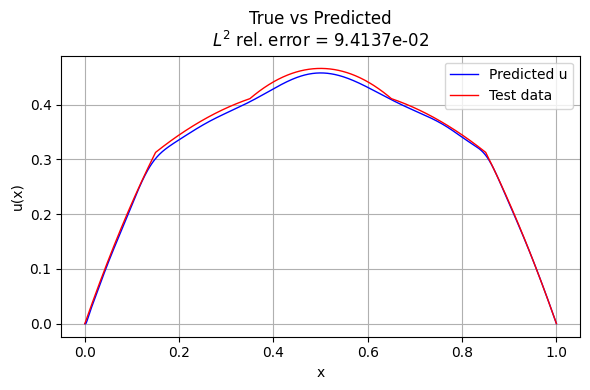

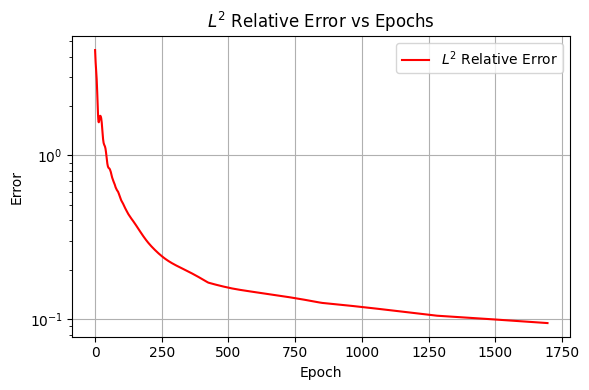

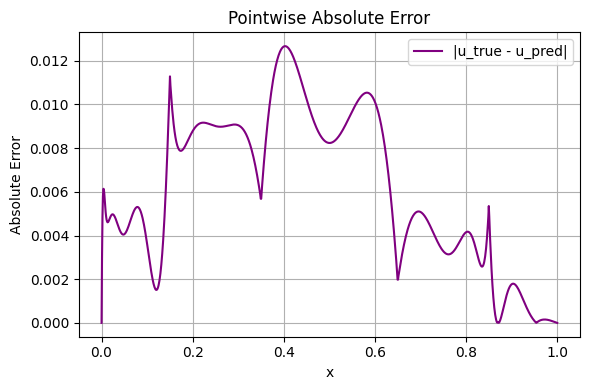

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.interpolate import interp1d

# Data
x_query = np.linspace(lb[0], ub[0], 1000)
x_query_torch = torch.tensor(x_query, dtype=dataType).reshape(-1, 1).to(device)

# Ground truth
u_true = torch.cos(torch.pi * 3 * x_query_torch / 2)

# Prediction with mollifier
with torch.no_grad():
    raw_pred = model_u(x_query_torch)
    u_query = raw_pred * x_query_torch * (1 - x_query_torch)

# Interpolating the test data
x_test_np = x_test.cpu().numpy().flatten()
u_test_np = u_test.cpu().numpy().flatten()

# Creating interpolation function
interp_func = interp1d(x_test_np, u_test_np, kind='cubic', bounds_error=False, fill_value='extrapolate')
u_true_interp = interp_func(x_query)
u_true_interp_torch = torch.tensor(u_true_interp, dtype=dataType).reshape(-1, 1).to(device)

# Error calculations
l2_error = torch.sqrt(torch.sum((u_true_interp_torch - u_query) ** 2) / torch.sum(u_true_interp_torch ** 2))
pointwise_error = torch.abs(u_true_interp_torch - u_query)

# To CPU for plotting
x_query_np = x_query_torch.cpu().numpy().flatten()
u_query_np = u_query.cpu().numpy().flatten()
u_true_np = u_true_interp_torch.cpu().numpy().flatten()
pointwise_error_np = pointwise_error.cpu().numpy().flatten()

#####################################
# Plot 1: True vs Predicted
#####################################
plt.figure(figsize=(6, 4))
plt.plot(x_query_np, u_query_np, label='Predicted u', color='blue', linewidth=1)
plt.plot(x_test_np, u_test_np, label='Test data', color='red', linewidth = 1)
plt.title(f'True vs Predicted\n$L^2$ rel. error = {error.item():.4e}')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#####################################
# Plot 2: L² Error vs Epochs
#####################################
plt.figure(figsize=(6, 4))
plt.semilogy(error_list, label='$L^2$ Relative Error', color='red')
plt.title('$L^2$ Relative Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#####################################
# Plot 3: Pointwise Absolute Error
#####################################
plt.figure(figsize=(6, 4))
plt.plot(x_query_np, pointwise_error_np, label='|u_true - u_pred|', color='purple')
plt.title('Pointwise Absolute Error')
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>
Shape of x_obs:  torch.Size([250, 1])
Shape of u_obs:  torch.Size([250, 1])
Shape of x_test:  torch.Size([1001, 1])
Shape of u_test:  torch.Size([1001, 1])
Shape of e_test:  torch.Size([1001, 1])


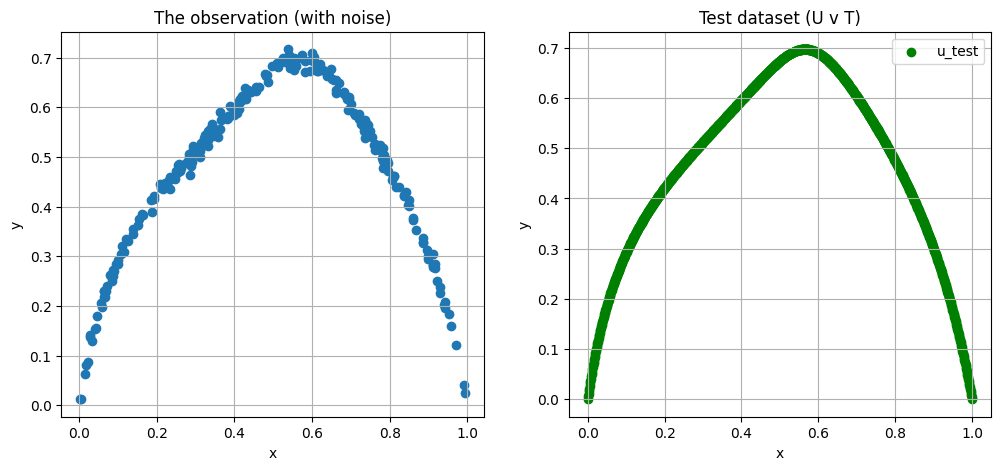

In [ ]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.interpolate import griddata

# float32 for memory efficiency
dataType = torch.float32

#
with h5py.File('/content/drive/MyDrive/DPL4PDE_Project/LinearElasticity1d_inverse.h5', 'r') as file:
    print(file.keys())
    #
    x_obs_dev = torch.tensor(np.array(file['x_obs']), dtype = dataType)
    u_obs_dev = torch.tensor(np.array(file['u_obs']), dtype = dataType)
    x_test_dev = torch.tensor(np.array(file['x_test']), dtype = dataType)
    u_test_dev = torch.tensor(np.array(file['u_test']), dtype = dataType)
    e_test_dev = torch.tensor(np.array(file['e_test']), dtype = dataType)

    x_obs = x_obs_dev.reshape(-1,1)
    u_obs = u_obs_dev.reshape(-1,1)
    x_test = x_test_dev.reshape(-1,1)
    u_test = u_test_dev.reshape(-1,1)
    e_test = e_test_dev.reshape(-1,1)

print(f'Shape of x_obs: ', x_obs.shape)
print(f'Shape of u_obs: ', u_obs.shape)
print(f'Shape of x_test: ', x_test.shape)
print(f'Shape of u_test: ', u_test.shape)
print(f'Shape of e_test: ', e_test.shape)

# Side-by-side comparison of observed vs true U fields
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].scatter(x_obs, u_obs, label='u_obs')
axs[0].set_title('The observation (with noise)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid(True)

axs[1].scatter(x_test, u_test, label='u_test', color='g')
axs[1].set_title('Test dataset (U v T)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].grid(True)

plt.legend()
plt.show()

# Inverse PINN

Solving the inverse problem with PINN.

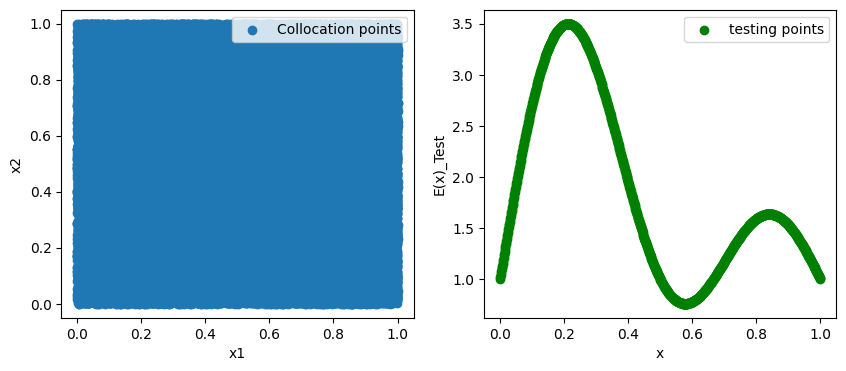

In [ ]:
# Multilayer perceptron Class
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x + torch.pi)
        return x

    def forward(self, x):
        # Input and hidden layers
        for layer in self.net[:-1]:
            x = layer(x)
            x = self.activation(x)

        # Returning output layer
        return torch.nn.functional.silu(self.net[-1](x))

####################################################
# For 1D input x ∈ [0, 1]
lb, ub = np.array([0.]), np.array([1.])
#
nc = 100000
dataType = torch.float32
np.random.seed(1234)

# Input conditions
x_in = np.random.uniform(lb, ub, (nc, 1))
x_in = torch.tensor(x_in, dtype=torch.float32)

###### The truth solution: for generating the testing dataset, the initial condition, and the boundary condition
def k_true(x):
    '''The ground truth solution'''
    return 2.0 + 0.5 * torch.sin(2 * np.pi * x)

################################# The collocation points (x,t)
x_in = np.random.uniform(lb, ub, (nc,2))
x_in = torch.tensor(x_in, dtype=dataType)

###################################
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(x_in[...,0], x_in[...,1], label='Collocation points')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].legend()
#
axes[1].scatter(x_test[:,0], e_test[:,0], color='g', label='testing points')
axes[1].set_xlabel('x')
axes[1].set_ylabel('E(x)_Test')
axes[1].legend()
plt.show()

In [ ]:
from torch.autograd import grad, Variable
device = torch.device('cpu')
print(f"Using device: {device}")
#
torch.manual_seed(1234)

##################
# Loss Class
##################
class LossClass(object):

    def __init__(self, u_model, e_model):
        self.device = device
        self.u_model = u_model # Displacement
        self.e_model = e_model # Young's modulus
        self.getLoss = torch.nn.MSELoss()

    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        du_dx = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        E = self.e_model(x)

        # Stress calculation
        stress = E * du_dx

        #
        d_stress_dx = grad(stress, x, grad_outputs=torch.ones_like(stress), create_graph=True)[0]

        # The residual
        residual = -d_stress_dx - 10 * torch.ones_like(stress)
        loss = self.getLoss(residual, torch.zeros_like(residual))

        return loss

    def loss_data(self, x_obs, u_obs):
        '''Loss from sensor data'''
        x = x_obs.to(self.device)
        u_pred = self.u_model(x)

        return self.getLoss(u_pred, u_obs.to(self.device))

    def loss_bc(self, x_bc):
        '''Loss for zero Dirichlet boundary condition'''
        x = x_bc.to(self.device)
        u_pred = self.u_model(x)

        return self.getLoss(u_pred, torch.zeros_like(u_pred))

    def get_error_u(self, x_test, u_test):
      '''Relative L2 error in displacement field'''
      x = x_test.to(self.device)
      u_true = u_test.to(self.device)
      u_pred = self.u_model(x)

      return torch.sqrt(torch.sum((u_pred-u_true) ** 2)/ torch.sum(u_true ** 2))

    def get_error_E(self, x_test, E_test):
      '''Relative L2 error in Young's modulus'''
      x = x_test.to(self.device)
      E_true = E_test.to(self.device)
      E_pred = self.e_model(x)

      return torch.sqrt(torch.sum((E_pred-E_true) ** 2)/ torch.sum(E_true ** 2))

########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
#
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x.reshape(-1, 1)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

## Boundary points
x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32)

############ Training setups
from tqdm import trange
#
epochs = 100
lr = 1e-3
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
model_E = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params = list(model_u.parameters()) + list(model_E.parameters()), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = epochs/4, gamma=0.5)

#####################
#The training process
#####################

# Loss weights
w_pde = 1.0
w_data = 200.0
w_bc = 10.0

# Training loop
error_u_list, error_E_list = [],  []
for epoch in trange(epochs):
    for x_batch in dataloader:
        lossClass = LossClass(model_u, model_E)
        ############# Calculate losses
        loss_pde = lossClass.loss_pde(x_batch)
        loss_data = lossClass.loss_data(x_obs, u_obs)
        loss_bc = lossClass.loss_bc(x_bc)

        loss_total = w_pde * loss_pde + w_data * loss_data + w_bc * loss_bc

        # Optimiser
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error_u = lossClass.get_error_u(x_test, u_test)
        error_u_list.append(error_u.item())
        error_E = lossClass.get_error_E(x_test, e_test)
        error_E_list.append(error_E.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss_total.item()}, LR: {scheduler.optimizer.param_groups[0]['lr']:.2e}")
        print(f"Relative L2 Error in u: {error_u.item():.4e}, in E: {error_E.item():.4e}")

Using device: cpu


 25%|██▌       | 25/100 [02:30<07:40,  6.14s/it]

Epoch 25, Loss: 0.21028272807598114, LR: 5.00e-04
Relative L2 Error in u: 2.4011e-02, in E: 1.7057e-01


 50%|█████     | 50/100 [05:20<06:43,  8.07s/it]

Epoch 50, Loss: 0.03154537081718445, LR: 2.50e-04
Relative L2 Error in u: 1.1198e-02, in E: 8.0373e-02


 75%|███████▌  | 75/100 [08:10<02:33,  6.13s/it]

Epoch 75, Loss: 0.025136280804872513, LR: 1.25e-04
Relative L2 Error in u: 7.7863e-03, in E: 6.8141e-02


100%|██████████| 100/100 [10:44<00:00,  6.44s/it]

Epoch 100, Loss: 0.025596074759960175, LR: 6.25e-05
Relative L2 Error in u: 6.4798e-03, in E: 6.5606e-02


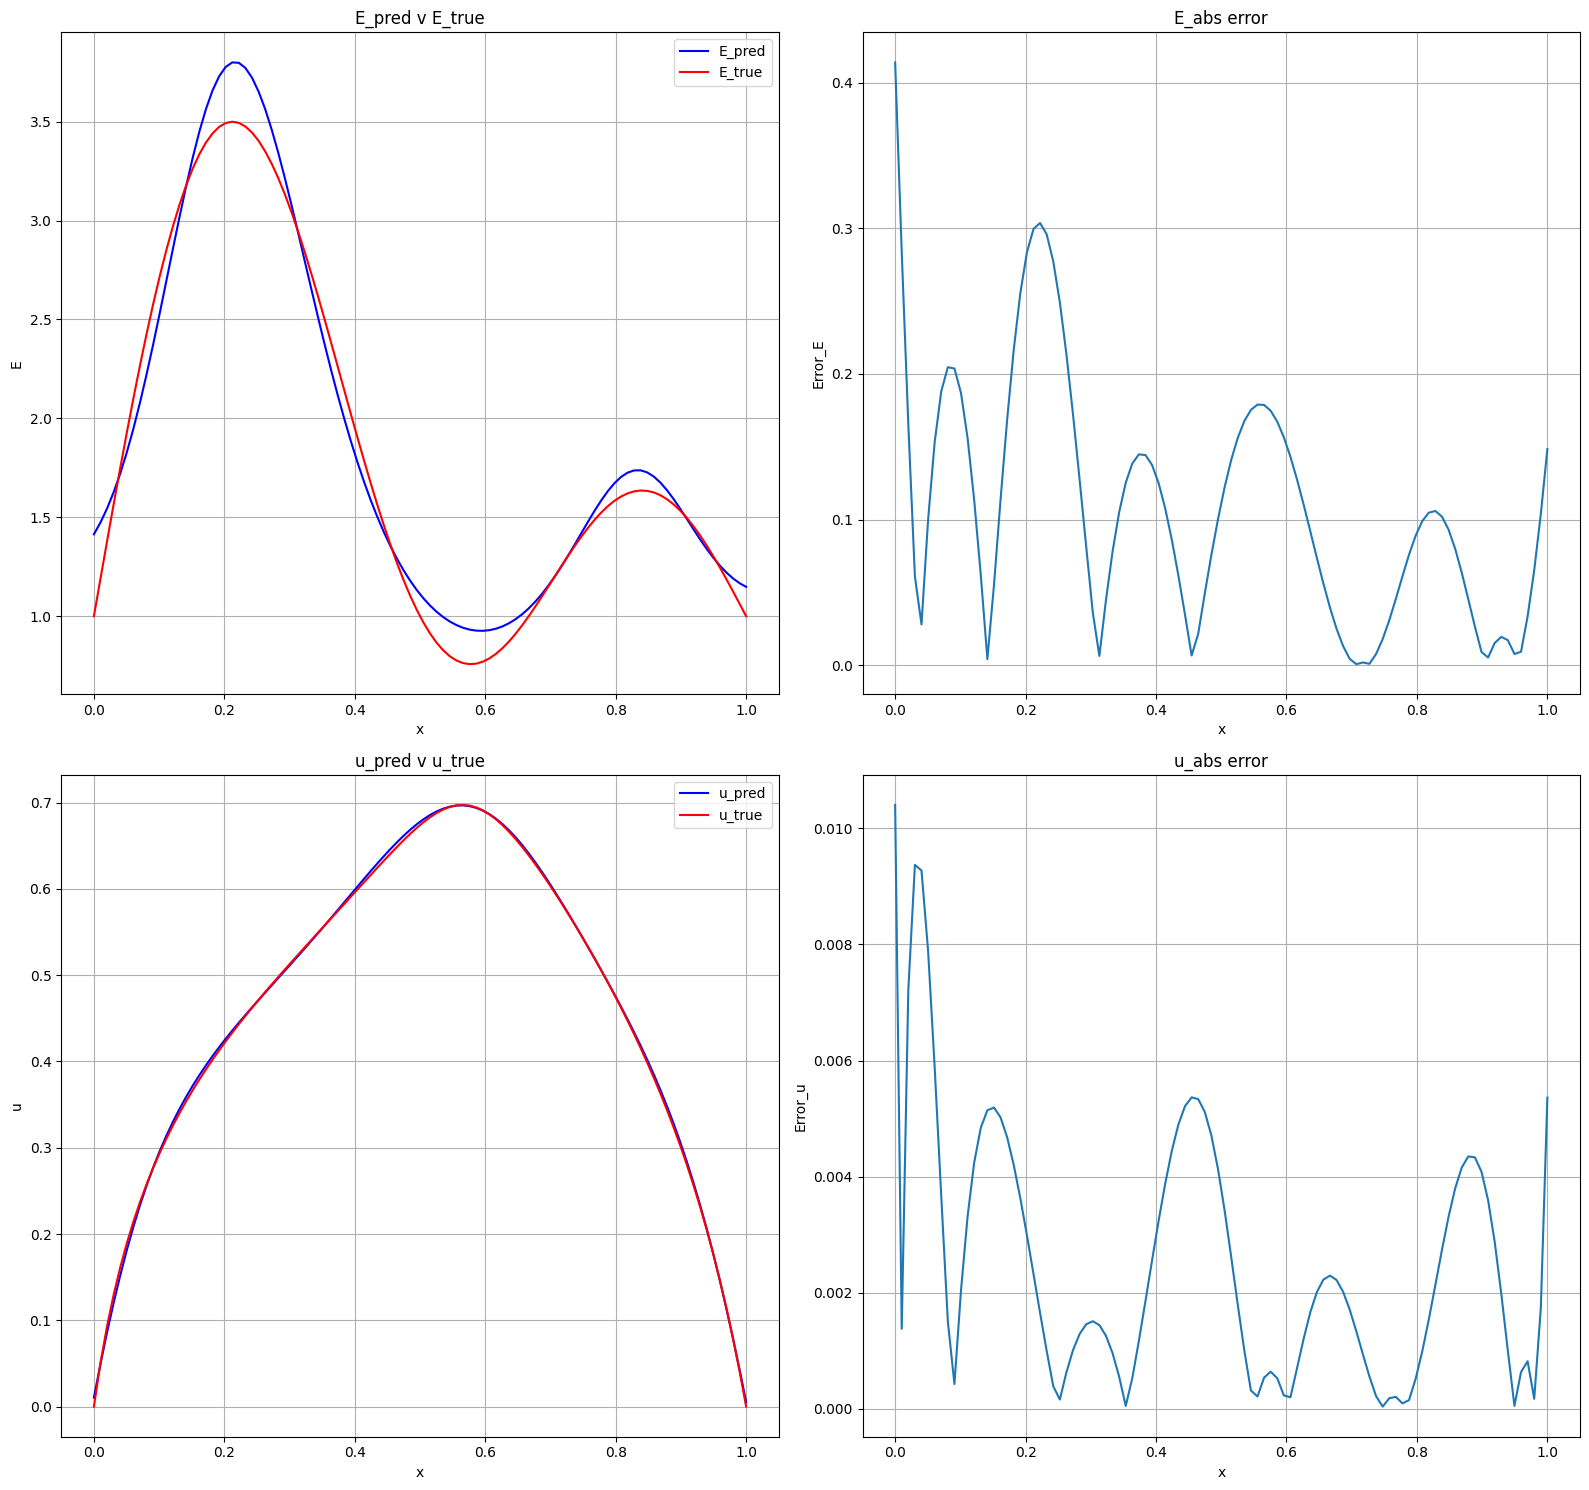

In [ ]:
#############################
# Prediction and visualisation
#############################

####### Make prediction with the trained model
x_query = x_test
# The prediction
u_query = model_u(x_query.to(device)).detach()
u_ref = u_test
E_query = model_E(x_query.to(device)).detach()
E_ref = e_test

# Grid for plotting
mesh = np.meshgrid(np.linspace(lb[0], ub[0], 100))
x1_plot = mesh[0]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15))

# Plot predicted and true Young's modulus
z_plot = griddata(x_query.numpy(), E_query.numpy().ravel(), (x1_plot,), method='cubic')
z_plot_E_true = griddata(x_query.numpy(), E_ref.numpy().ravel(), (x1_plot,), method='cubic')
cntr = axs.flat[0].plot(x1_plot, z_plot, label='E_pred', color='blue')
axs.flat[0].plot(x1_plot, z_plot_E_true, label='E_true', color='red')
axs.flat[0].set_title('E_pred v E_true')
axs.flat[0].set_xlabel('x')
axs.flat[0].set_ylabel('E')
axs.flat[0].legend()
axs.flat[0].grid(True)

# Absolute error in E
z_plot = griddata(x_query.numpy(), np.abs((E_query - E_ref).numpy().ravel()), (x1_plot,), method='cubic')
axs.flat[1].plot(x1_plot, z_plot)
axs.flat[1].set_title('E_abs error')
axs.flat[1].set_xlabel('x')
axs.flat[1].set_ylabel('Error_E')
axs.flat[1].grid(True)

# Predicted v Ground Truth u
z_plot = griddata(x_query.numpy(), u_query.numpy().ravel(), (x1_plot,), method='cubic')
z_plot_ref = griddata(x_query.numpy(), u_ref.numpy().ravel(), (x1_plot,), method='cubic')
axs.flat[2].plot(x1_plot, z_plot, label='u_pred', color='blue')
axs.flat[2].plot(x1_plot, z_plot_ref, label='u_true', color='red')
axs.flat[2].set_title('u_pred v u_true')
axs.flat[2].set_xlabel('x')
axs.flat[2].set_ylabel('u')
axs.flat[2].legend()
axs.flat[2].grid(True)


# Absolute error in u
z_plot = griddata(x_query.numpy(), np.abs((u_query - u_ref).numpy().ravel()), (x1_plot,), method='cubic')
axs.flat[3].plot(x1_plot, z_plot)
axs.flat[3].set_title('u_abs error')
axs.flat[3].set_xlabel('x')
axs.flat[3].set_ylabel('Error_u')
axs.flat[3].grid(True)

plt.tight_layout()
plt.show()

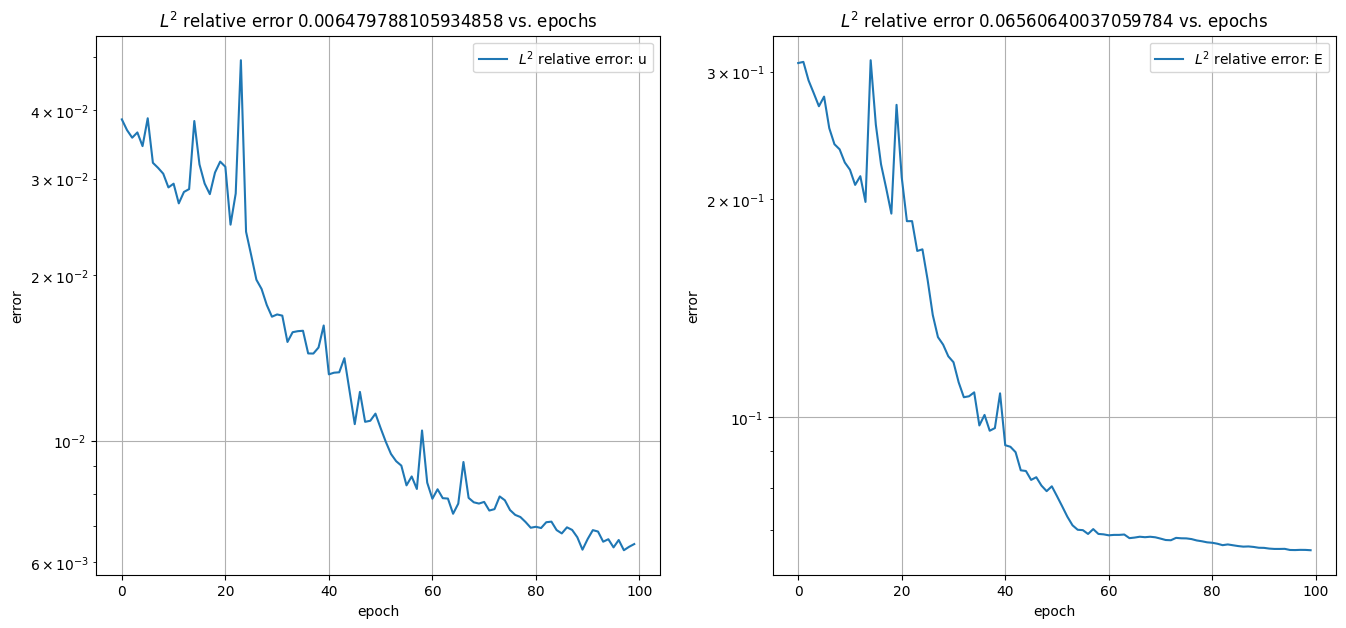

In [ ]:
error_u = torch.sqrt(torch.sum((u_ref-u_query)**2)/torch.sum(u_ref**2))
error_E = torch.sqrt(torch.sum((E_ref-E_query)**2)/torch.sum(E_ref**2))

# L^2 relative error: u
fig, axes = plt.subplots(1, 2, figsize=(16,7))
axes[0].semilogy(error_u_list, label='$L^2$ relative error: u')
axes[0].set_title(f'$L^2$ relative error {error_u} vs. epochs')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('error')
axes[0].legend()
axes[0].grid(True)

# L^2 relative error: E
axes[1].semilogy(error_E_list, label='$L^2$ relative error: E')
axes[1].set_title(f'$L^2$ relative error {error_E} vs. epochs')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('error')
axes[1].legend()
axes[1].grid(True)

#
plt.show()